In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import cifar10
import time

# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   annealing - a list specifying the annealing schedule for the learning rate
#     'none' - use a constant learning rate
#     ['step', k] - decay the learning rate to 0 at k evenly spaced times with identical steps
#     ['exp', k] - decay the learning rate exponentially alpha = alpha0(exp(-k*epoch))
#     ['inv', k] - decay the learning rate as alpha = alpha0/(1 + k*epoch)
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, annealing = 'none', lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # annealing policy
        self.annealing = annealing
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, valX, valY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        validationAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))
            
        alpha = self.alpha

        for epoch in np.arange(0,epochs):
            
            if self.annealing[0] == 'step':
                stepSize = self.alpha/self.annealing[1]
                if epochs > 0 and epoch % self.annealing[1] == 0:
                    alpha -= stepSize
                    print(alpha)
                
            elif self.annealing[0] == 'exp':
                alpha = self.alpha * np.exp(-self.annealing[1] * epoch)
                    
            elif self.annealing[0] == 'inv':
                alpha = self.alpha / (1 + self.annealing[1] * epoch)
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer])
                                + (self.lambda2 / numberOfExamples) * self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(valX)
                    predictedY = predictedY.argmax(axis=1)
                    validationAccuracy = accuracy_score(valY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    validationAccuracies.append(validationAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    
                    loss = self.computeLoss(X,y)
                    losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, validation accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, validationAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    #losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
                    print('[INFO] Epoch =', epoch + 1, 'of', epochs)

        # if we chose to print the performance, plot loss, training accuracy, and validation accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), validationAccuracies, label = 'Accuracy (validation)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

In [7]:
# load a specified amount of MNIST images

#data = mnist.load_data()

#numberOfImages = 60000

# The datapoints are in mnistData[0][0]
#X = data[0][0][:numberOfImages].reshape([numberOfImages,28*28]).astype('float')

# Normalize the data
#X = X/255.0

# The labels are in mnistData[0][1]
#Y = data[0][1][:numberOfImages]

# randomly choose 75% of the data to be the traini(ng set and 25% for the validation set
#(trainX, valX, trainY, valY) = train_test_split(X, Y, test_size = 0.25)

In [8]:
# load the full MNIST dataset

data = mnist.load_data()

((trainX, trainY), (valX, valY)) = mnist.load_data()

trainX = trainX.reshape((trainX.shape[0], 28 * 28 * 1))
valX = valX.reshape((valX.shape[0], 28 * 28 * 1))

trainX = trainX/255.0
valX = valX/255.0

[INFO] Now training the neural network
[INFO] Neural network training is finished after 225.006530046463 seconds
[INFO] Training set accuracy is 0.9777333333333333
[INFO] Validation set accuracy is 0.9508


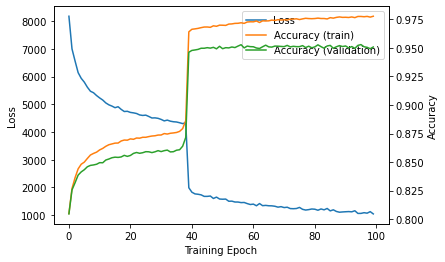

In [10]:
start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([trainX.shape[1], 30, 10], 0.1, 'none', 0.0, 0.0, 32, 0.0,
                                 ['normal', 1], 'sigmoid', 'sum-of-squares')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

[INFO] Now training the neural network
[INFO] Neural network training is finished after 260.6035990715027 seconds
[INFO] Training set accuracy is 0.98755
[INFO] Validation set accuracy is 0.9549


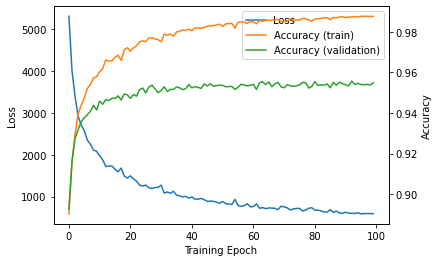

In [11]:
start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([trainX.shape[1], 30, 30, 10], 0.1, 'none', 0.0, 0.0, 32, 0.0,
                                 ['normal', 1], 'sigmoid', 'sum-of-squares')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

[INFO] Now training the neural network
[INFO] Neural network training is finished after 306.39830780029297 seconds
[INFO] Training set accuracy is 0.9886833333333334
[INFO] Validation set accuracy is 0.9533


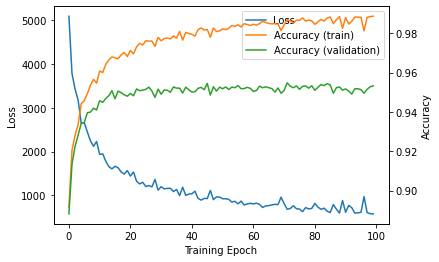

In [12]:
start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([trainX.shape[1], 30, 30, 30, 10], 0.1, 'none', 0.0, 0.0, 32, 0.0,
                                 ['normal', 1], 'sigmoid', 'sum-of-squares')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

[INFO] Now training the neural network
[INFO] Neural network training is finished after 665.223682641983 seconds
[INFO] Training set accuracy is 0.9894
[INFO] Validation set accuracy is 0.9548


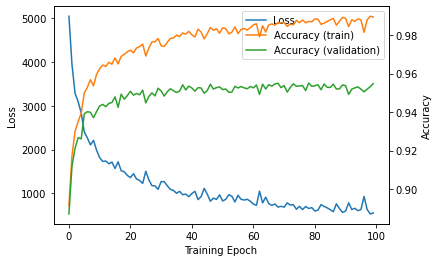

In [15]:
start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([trainX.shape[1], 30, 30, 30, 30, 10], 0.1, 'none', 0.0, 0.0, 32, 0.0,
                                 ['normal', 1], 'sigmoid', 'sum-of-squares')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))

[INFO] Now training the neural network
[INFO] Neural network training is finished after 771.0620396137238 seconds
[INFO] Training set accuracy is 0.98625
[INFO] Validation set accuracy is 0.9532


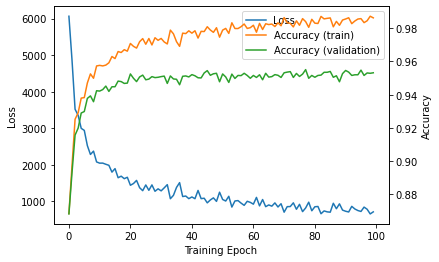

In [16]:
start = time.time()

# fit the model to the training data
print('[INFO] Now training the neural network')

model = FeedforwardNeuralNetwork([trainX.shape[1], 30, 30, 30, 30, 30, 10], 0.1, 'none', 0.0, 0.0, 32, 0.0,
                                 ['normal', 1], 'sigmoid', 'sum-of-squares')

model.fit(trainX, trainY, valX, valY, 100, 1)

end = time.time()

print('[INFO] Neural network training is finished after', end - start, 'seconds')

# Compute the outputs and measure the accuracy on the train and validation sets
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print('[INFO] Training set accuracy is', accuracy_score(trainY, predictedY))

valY = LabelBinarizer().fit_transform(valY)
predictedY = model.predict(valX)
predictedY = predictedY.argmax(axis=1)
valY = valY.argmax(axis=1)
print('[INFO] Validation set accuracy is', accuracy_score(valY, predictedY))